In [2]:
#%pip install torchvision
import matplotlib.pyplot as plt
import librosa
from torch.utils.data import DataLoader
import torch.utils.data 

from torch import nn, optim

import numpy as np
from numpy.fft import fft, fftshift,ifft,ifftshift

from AudioMNISTlin import AudioMNIST
import custom_transforms as CT

from tqdm.notebook import tqdm

import lightning.pytorch as pl
import torch.nn.functional as F
from IPython.display import Audio
import torchvision.transforms as T


/home/woreom/miniconda3/envs/adv/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/woreom/miniconda3/envs/adv/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### Let us create an AudioMNIST dataset which uses the absolute value of the FFT as the transform, creating datapoints that are 1D vectors

In [3]:
SAMPLE_RATE = 22050
SAMPLE_RND = 22016
dataset = AudioMNIST(
    root='./AudioMNIST/data', 
    target_sample_rate=SAMPLE_RATE,
    transform=T.Compose([
        CT.FixLength(SAMPLE_RND),
        CT.FFT()
    ]),
    normalize=False
)

In [4]:
total_dataset_length = len(dataset)
validation_dataset_length = int(total_dataset_length * 0.1)
train_dataset_length = total_dataset_length - validation_dataset_length
validation_dataset, _ = torch.utils.data.random_split(dataset, [train_dataset_length, validation_dataset_length])
train_loader = DataLoader(
        dataset,
        batch_size = 64,
        shuffle=True,
        num_workers=4
)
validation_loader = DataLoader(
        validation_dataset,
        batch_size = 1,
        shuffle=False,
        num_workers=4
)

In [5]:
tst_data, label = next(iter(validation_loader))

In [6]:
print("Input shape:", tst_data.shape)
print(tst_data.max(), tst_data.min())
### Do normalization in the forward, as is now, or add it to the transforms

Input shape: torch.Size([1, 1, 22016])
tensor(6.7479) tensor(7.3034e-06)


### If we do inverse FFT (ifft), we will get back the original sampled content of the .wav file

In [8]:
inverse = np.abs(fftshift(ifft(ifftshift(tst_data.squeeze().numpy()))))
x= fftshift(np.fft.fftfreq(tst_data.shape[-1]))

label: tensor([7])


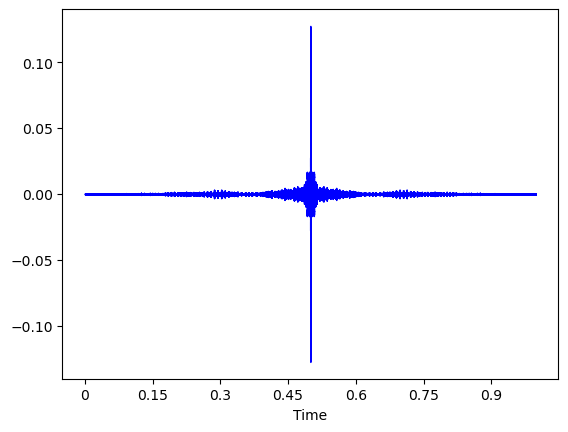

In [9]:
librosa.display.waveshow(inverse, sr=SAMPLE_RATE, color="blue")   #show the inverse

print(f"label: {label}")
Audio(data=inverse, rate=SAMPLE_RATE) # play the inverse

### Let us plot the datapoint (FFT coefficients of the .wav file)

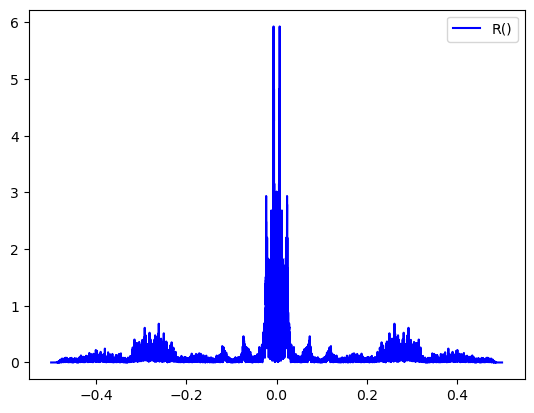

In [10]:
import matplotlib.pyplot as pyplot
f = pyplot.figure()
ax = f.add_subplot(111)
ax.plot(x, tst_data.squeeze().numpy(), 'b', label='R()')
ax.legend()

### This is an example of the 1D encoder -- continue in the similar fashion by creating a 1D decoder, and integrate the two with a codebook of dimension 512 x 32

In [10]:
from itertools import chain
class Encoder(nn.Module):
    def __init__(self, input_channels, hidden_sizes, codebook_dim):
        super(Encoder, self).__init__()
        
        layers = []
        layer_sizes = list(chain([input_channels], hidden_sizes, [codebook_dim]))
        
        for input_size, output_size in zip(layer_sizes[:-1], layer_sizes[1:]):
            layers.append(nn.Conv1d(input_size, output_size, 3, padding = 1, stride = 2))
            layers.append(nn.InstanceNorm1d(output_size))
            layers.append(nn.ReLU())
        
        self.encoder = nn.Sequential(*layers)
        self.codebook_dim = codebook_dim

    def forward(self, x):
        z_e = self.encoder(x)
        return z_e


e = Encoder(1, [256, 256, 128, 64], 64)
e = e.to('cpu')
from torchinfo import summary

print(tst_data.shape)
summary(e, input_size=(1, 1, 22016), row_settings=("depth", "ascii_only"))

# print(e(tst_data).shape)

torch.Size([1, 1, 22016])


Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [1, 64, 688]              --
+ Sequential: 1-1                        [1, 64, 688]              --
|    + Conv1d: 2-1                       [1, 256, 11008]           1,024
|    + InstanceNorm1d: 2-2               [1, 256, 11008]           --
|    + ReLU: 2-3                         [1, 256, 11008]           --
|    + Conv1d: 2-4                       [1, 256, 5504]            196,864
|    + InstanceNorm1d: 2-5               [1, 256, 5504]            --
|    + ReLU: 2-6                         [1, 256, 5504]            --
|    + Conv1d: 2-7                       [1, 128, 2752]            98,432
|    + InstanceNorm1d: 2-8               [1, 128, 2752]            --
|    + ReLU: 2-9                         [1, 128, 2752]            --
|    + Conv1d: 2-10                      [1, 64, 1376]             24,640
|    + InstanceNorm1d: 2-11              [1, 64, 1376]             --

### Hence, make the codebook of dimension 32. Each of the 688 slices of the encoder output will be quantized to one codeword (of length 32) from the codebook
